In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from data_processing import dataSet, numeric_plots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from catboost import CatBoostRegressor
import xgboost as xgb

In [2]:
sns.set()
sns.set(rc={'figure.figsize':(8,8)})
sns.set_palette('bright')

In [3]:
RANDOM_SEED = 42

# 2. Машинное обучение.

В этом ноутбуке опробованы различные алгоритмы машинного обучения и проведено сравнение результатов. Рассмотрены алгоритмы:
* OLS-регрессия (красиво взрывается)
* RIDGE-регрессия
* Бэггинг над RIDGE-регрессией
* K ближайших соседей
* Random Forest
* XGBoost
* CatBoost

Почти для всех алгоритмов на кросс-валидации подобраны некоторые гиперпараметры.

В разделе 2.2. применено ансамблирование получившихся алгоритмов (наивное усреднение и стэкинг), как всех сразу, так и только топ-3 по результатам метрики.

Осторожно: довольно требовательно к ресурсам компьютера! Датасет большой, плюс некоторые моменты сделаны неоптимально, например иногда заново фитим алгоритмы на тех же данных. В виду сжатых  сроков полировка и оптимизация некоторых кусков не проводилась. Полный прогон ноутбука на core i5 9го поколения занимает ночь и требует 32 гБ оперативной памяти.

## 2.0. Подготовка данных.

Для начала загрузим и обработаем данные (при помощи написанного при EDA класса) и отделим от трейна отложенную выборку. Также переставим столбцы в тесте для кэггла в том же порядке, в каком они идут в основных данных.

In [4]:
dropcols = ['date_posted', 'views_total', 
            'views_today', 'url', 'catalog_link', 
            'orig_url', 'vin', 'license_plate']
dummy_cols = ['brand', 'model', 'generation', 
              'body_type', 'color', 'fuel_type', 
              'transmission', 'drive', 'wheel', 
              'state', 'pts', 'customs', 'exchange']
test_set = dataSet.from_csv('./input/test_scraped.csv', is_test = True)
test_no_dummies = test_set.prepare_frame_no_dummies(orig_test_path = './input/test.csv')
test_with_dummies = test_set.prepare_frame_with_dummies(dummy_cols)

train_set = dataSet.from_csv('./input/dataset_with_electro.csv', is_test= False)
train_no_dummies = train_set.prepare_frame_no_dummies(
                    test_no_dummies.brand.unique(),
                    test_no_dummies.model.unique())
train_with_dummies = train_set.prepare_frame_with_dummies(dummy_cols)

train_with_dummies, test_with_dummies = dataSet.equalize_columns(train_with_dummies, 
                                                                 test_with_dummies)

train_no_dummies.drop(columns = dropcols, inplace = True)
test_no_dummies.drop(columns = dropcols, inplace = True)
train_with_dummies.drop(columns = dropcols, inplace = True)
test_with_dummies.drop(columns = dropcols, inplace = True)

train_no_dummies.set_index('offer_id', inplace=True)
train_with_dummies.set_index('offer_id', inplace=True)
test_no_dummies.set_index('offer_id', inplace=True)
test_with_dummies.set_index('offer_id', inplace=True)

/home/rivfader/anaconda3/envs/autoru/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
            train_with_dummies.drop(columns = ['log_price']), 
            train_with_dummies.log_price, test_size = 0.3)
kaggle_test = test_with_dummies.drop(columns=['log_price'])[X_test.columns]
X_full, y_full = train_with_dummies.drop(columns = ['log_price']), train_with_dummies.log_price

In [6]:
def make_submission(clf, filename, inflation_factor = 1):
    '''Автоматически делаем предсказине обученной моделью по выборке 
    для кэггла и записываем в файл. Предикт умножаем на inflation_factor, 
    чтобы скомпенсировать инфляцию за период времени, прошедший от сбора цен проверочной
    выборки с кэггла и от сбора обучающих данных.
    '''
    y_pred = clf.predict(kaggle_test)
    sub = pd.concat([pd.Series(test_with_dummies.index).apply(lambda x: str(x)[:-2]),
                     pd.Series(inflation_factor*np.exp(y_pred))], axis=1).rename(
                                columns = {'offer_id':'sell_id', 0:'price'})
    sub.to_csv(filename, index=False)

In [7]:
def mapes(y_true, y_pred):
    '''
    Печатаем MAPE для логарифма цены и для цены в рублях, возвращаем эти значения
    для сохранения в словаре с результатами.
    '''
    mape_log = mape(y_true, y_pred)
    mape_rub = mape(np.exp(y_true), np.exp(y_pred))
    print(f'MAPE для логарифма цены: {mape_log}')
    print(f'MAPE для цены в рублях: {mape_rub}')
    return mape_log, mape_rub 

results = {}

## 2.1. Эксперименты над отдельными алгоритмами.
### 2.1.0. Простая линейная регрессия

Попробуем простейший метод линейной регресии. Ничего хорошего не ждём, у нас есть коррелирующие столбцы в матрице плана.

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [9]:
mape(y_test, y_pred)

1489.5968456370083

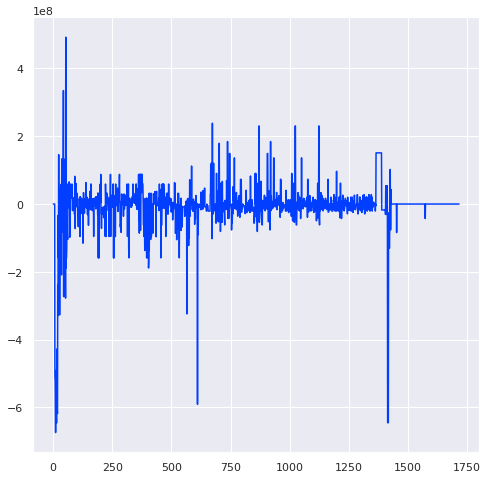

In [10]:
plt.plot(lr.coef_)

Линейная регрессия взорвалась. Прикольно. Это потому что матрица $X^T X$ очевидно близка к необратимой. Выкинем объём двигателя.

In [11]:
lr = LinearRegression()
lr.fit(X_train.drop(columns=['engine_volume']), y_train)
y_pred = lr.predict(X_test.drop(columns=['engine_volume']))

In [12]:
mape(y_test, y_pred)

2449.6103047491115

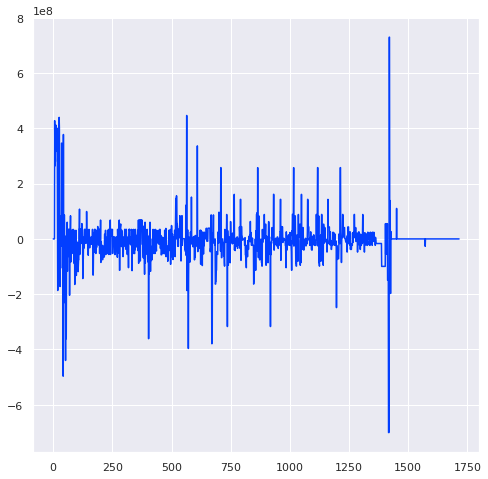

In [13]:
plt.plot(lr.coef_)

Не особо помогает. Видимо, мультиколлинеарности там много. Регуляризация!

### 2.1.1. RIDGE regression

In [14]:
ridge = Ridge(random_state=RANDOM_SEED)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
results["Ridge_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.011227999304165152
MAPE для цены в рублях: 0.14938399425590476


Ну вот, другое дело. Потюним гиперпараметры.

In [15]:
search_grid_lr = {
    'alpha':[0.5, 1, 2, 4, 6],
    'max_iter': [100, 1000, 10000],
}
gridsearch_lr = GridSearchCV(estimator = ridge, 
                             param_grid = search_grid_lr, 
                             scoring='neg_mean_absolute_percentage_error', 
                             n_jobs=-1, 
                             verbose = 2)
gridsearch_lr.fit(X_train, y_train)
best_lr = gridsearch_lr.best_estimator_
print(best_lr)
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
results["Ridge_tuned"] = mapes(y_test, y_pred)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Ridge(alpha=0.5, max_iter=100, random_state=42)
MAPE для логарифма цены: 0.01120699898532855
MAPE для цены в рублях: 0.149055808028866


In [16]:
best_lr.fit(X_full, y_full)
make_submission(best_lr, './output/best_ridge_no_correction.csv')

Результат на кэгле - 17.76. Либо переобучение, либо инфляция (обучающий датасет на полгода старше тренировочного).
Для улучшения MAPE на кэггловсокй выборке придётся модифицировать либо обучающую выборку (уменьшать цены в ней на несколько процентов), либо предикт (уменьшать его на несколько процентов). По-хорошему нужно найти статистику по изменению цен на конкретные модели автомобилей, чтобы изменять не всю выборку разом, а отдельно для каждой модели. Но такой статистики в удобоваримом виде найти не удалось.
Эксперименты показали, что достаточно модифицировать предикт. Уменьшение на 9% улучшает MAPE на несколько единиц.

In [17]:
make_submission(best_lr, './output/best_ridge_correction.csv', 0.91)

Сразу стало 14.74. Интересно попробовать бэггинг.

In [18]:
bagger_lr = BaggingRegressor(base_estimator=best_lr, random_state=RANDOM_SEED, n_estimators=20)
bagger_lr.fit(X_train, y_train)
y_pred = bagger_lr.predict(X_test)
results["ridge_bagging"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.011219402355374988
MAPE для цены в рублях: 0.14906306992606855


Поробовали, если трогать другие параметры (max_samples, max_features), то становится только хуже.

In [19]:
bagger_lr.fit(X_full, y_full)
make_submission(bagger_lr, './output/bagger_lr_correction.csv', 0.91)

### 2.1.2. K ближайших соседей.

Несмотря на то, что knn в основном ииспользуется для классификации, регрессор на этом алгоритме тоже есть. Попробуем.

In [20]:
knr = KNeighborsRegressor(n_neighbors=3)
knr.fit(X_train, y_train)
y_pred = knr.predict(X_test)
results["KNNR_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.014389083182167813
MAPE для цены в рублях: 0.19101661285494873


К ближайших соседей не очень хорошо себя показал, и очень меделнно работает. Попытка потюнить гиперпараметры не удалась - ОЧЕНЬ долго считается. Тем не менее, попробуем включить его в стекинг.

In [21]:
knr.fit(X_full, y_full)
make_submission(knr, './output/knr_no_correction.csv')
make_submission(knr, './output/knr_correction.csv', 0.91)

### 2.1.3. Random Forest.

In [22]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs=-1, verbose = False)

In [23]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [24]:
results["random_forest_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.010685305146578896
MAPE для цены в рублях: 0.14155231682666897


<AxesSubplot:>

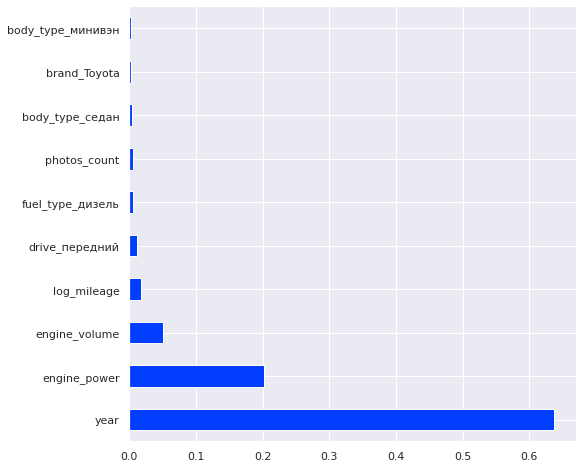

In [25]:
(pd.Series(rf.feature_importances_, index = X_train.columns)
     .sort_values(ascending = False)
     .iloc[0:10].plot(kind = 'barh'))

In [26]:
rf.fit(X_full, y_full)
make_submission(rf, './output/random_forest_no_correction.csv')
make_submission(rf, './output/random_forest_correction.csv', 0.91)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [27]:
search_grid_rf = {
    'n_estimators':[100, 200],
    'max_depth': [None, 100],
}
gridsearch = GridSearchCV(estimator = rf, 
                          param_grid = search_grid_rf, 
                          scoring='neg_mean_absolute_percentage_error', 
                          n_jobs=-1, verbose = 3)
gridsearch.fit(X_train, y_train)
best_rf = gridsearch.best_estimator_
print(best_rf)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
results["random_forest_tuned"] = mapes(y_test, y_pred)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42,
                      verbose=True)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


MAPE для логарифма цены: 0.010660378007621865
MAPE для цены в рублях: 0.14121270858656138


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


Random Forest лучше ридж-регресии, но не драматически (не в разы).

In [28]:
best_rf.fit(X_full, y_full)
make_submission(best_rf, './output/best_rf_no_correction.csv')
make_submission(best_rf, './output/best_rf_correction.csv', 0.91)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished


### 2.1.4. XGBOOST

In [29]:
xgbr = xgb.XGBRegressor(verbosity=1, random_state=RANDOM_SEED)

In [30]:
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)
results["xgboost_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.011546430028532976
MAPE для цены в рублях: 0.15475434079032768


In [31]:
xgbr.fit(X_full, y_full)
make_submission(xgbr, './output/xgb_no_correction.csv')
make_submission(xgbr, './output/xgb_correction.csv', 0.91)

In [32]:
xgb_param_grid =  {
        'learning_rate' : [0.1, 0.3] ,
        'min_child_weight' : [ 1, 3]}
    
gridsearch_xgb = GridSearchCV(estimator = xgbr, 
                              param_grid = xgb_param_grid, 
                              scoring='neg_mean_absolute_percentage_error', 
                              n_jobs=-1)

In [33]:
gridsearch_xgb.fit(X_train, y_train)
best_xgb = gridsearch_xgb.best_estimator_
print(best_xgb)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
results["xgboost_tuned"] = mapes(y_test, y_pred)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)
MAPE для логарифма цены: 0.011559605026353418
MAPE для цены в рублях: 0.15501101818423604


In [34]:
best_xgb.fit(X_full, y_full)
make_submission(best_xgb, './output/best_xgb_no_correction.csv')
make_submission(best_xgb, './output/best_xgb_correction.csv', 0.91)

Результаты не впечатляют, хуже регрессии. Но это, возможно, от некорректного подбора гиперапараметров.

### 2.1.5. CatBoost.

In [35]:
cr = CatBoostRegressor(logging_level = 'Silent', 
                       task_type="CPU", 
                       random_seed=RANDOM_SEED)
cr.fit(X_train, y_train)
y_pred = cr.predict(X_test)
results["catboost_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.010794935586246692
MAPE для цены в рублях: 0.14358947094245655


In [36]:
cr.fit(X_full, y_full)
make_submission(cr, './output/catboost_no_correction.csv')
make_submission(cr, './output/catboost_correction.csv', 0.91)

In [37]:
cr_params =  {"iterations": [1000, 2000],
              "depth": [4,8]}
gridsearch_cat = GridSearchCV(estimator = cr, param_grid = cr_params, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
gridsearch_cat.fit(X_train, y_train)
best_cat = gridsearch_cat.best_estimator_
print(best_cat.get_params())

{'iterations': 2000, 'depth': 8, 'loss_function': 'RMSE', 'random_seed': 42, 'logging_level': 'Silent', 'task_type': 'CPU'}


In [38]:
best_cat.fit(X_train, y_train)
y_pred = best_cat.predict(X_test)
results["catboost_tuned"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.010400122306655669
MAPE для цены в рублях: 0.1380743441722558


In [39]:
best_cat.fit(X_full, y_full)
make_submission(best_cat, './output/best_cat_no_correction.csv')
make_submission(best_cat, './output/best_cat_correction.csv', 0.91)

Подбор гиперпараметров позволил улучшить метрику.

### 2.1.6. Деревья (и бэггинг над ними как в random forest)

Сначала попробуем просто дерево. Ожидается переобучение.

In [40]:
treereg = DecisionTreeRegressor(random_state=RANDOM_SEED)
treereg.fit(X_train, y_train)
y_pred = treereg.predict(X_test)
results["tree_basic"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.015088421386596945
MAPE для цены в рублях: 0.2088213332469702


<AxesSubplot:>

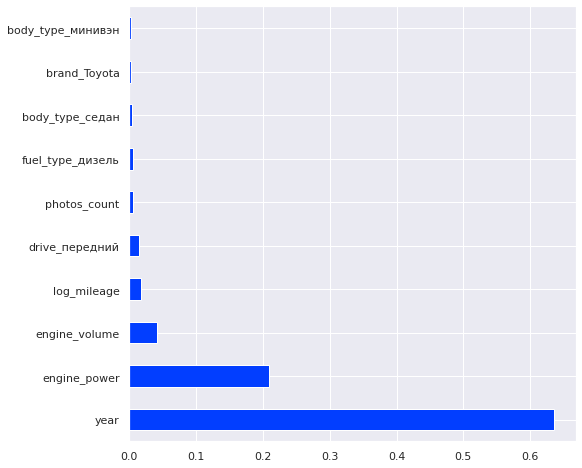

In [41]:
(pd.Series(treereg.feature_importances_, index = X_train.columns)
     .sort_values(ascending = False)
     .iloc[0:10].plot(kind = 'barh'))

In [42]:
tree_params =  {'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_split': [5, 10, 25, 50, 75, 100, 200],
               'max_depth': [10,20,50]}
gridsearch_tree = GridSearchCV(estimator = treereg, param_grid = tree_params, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
gridsearch_tree.fit(X_train, y_train)
best_tree = gridsearch_tree.best_estimator_
best_tree.fit(X_train, y_train)
y_pred = best_tree.predict(X_test)
print(best_tree)
results["tree_tuned"] = mapes(y_test, y_pred)

DecisionTreeRegressor(max_depth=20, max_features='auto', min_samples_split=50,
                      random_state=42)
MAPE для логарифма цены: 0.012421109526012684
MAPE для цены в рублях: 0.16775912167664447


In [43]:
bagger_tree = BaggingRegressor(base_estimator=best_tree)
bagger_tree.fit(X_train, y_train)
y_pred = bagger_tree.predict(X_test)
results["tree_bagging"] = mapes(y_test, y_pred)

MAPE для логарифма цены: 0.011205855199017905
MAPE для цены в рублях: 0.14933169876025146


In [46]:
bag_params =  {'n_estimators': [10, 50, 100],
              'max_samples': [0.5, 0.75, 1.0],
               'max_features': [0.5, 0.75, 1.0]}
gridsearch_bag = GridSearchCV(estimator = bagger_tree, param_grid = bag_params, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
gridsearch_bag.fit(X_train, y_train)
best_bag_tree = gridsearch_bag.best_estimator_
best_bag_tree.fit(X_train, y_train)
y_pred = best_bag_tree.predict(X_test)
print(best_bag_tree)
results["tree_bagging_tuned"] = mapes(y_test, y_pred)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20,
                                                      max_features='auto',
                                                      min_samples_split=50,
                                                      random_state=42),
                 max_features=0.75, n_estimators=100)
MAPE для логарифма цены: 0.010885492682865176
MAPE для цены в рублях: 0.146389904583857


Бэггинг улучшает работу дерева, впрочем это получается аналог random forest.

### 2.1.7. Результаты.

In [ ]:
print(results)

Наши чемпионы - CatBoost, бэггинг над линейной регрессией и random forest.

## 2.2. Ансамблирование.

### 2.2.0. Наивное усреднение

Просто усредним предсказания моделей.

In [47]:
class AverageModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [48]:
aver = AverageModel([best_lr, bagger_lr, knr, best_rf, best_xgb, best_cat, best_tree, best_bag_tree])

In [49]:
aver.fit(X_train, y_train)
y_pred = aver.predict(X_test)
results["average_all"] = mapes(y_test, y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


MAPE для логарифма цены: 0.010341781484437443
MAPE для цены в рублях: 0.13675592079827906


In [50]:
aver.fit(X_full, y_full)
make_submission(aver, './output/aver_no_correction.csv')
make_submission(aver, './output/aver_correction.csv', 0.91)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished


Даже простенькое усреднение очень хорошо себя показывает по метрике.

### 2.2.2. Stacking

Попробуем подобрать мета-алгоритм для ансамбля из всех моделей с подобранными гиперпараметрами, а потом применим его к ансамблю из топ-3 алгоритмов по MAPE. 
Расчёт занимает несколько часов. Его наверняка можно оптимизировать, но в виду сжатых сроков он просто оставлен на ночь.

In [10]:
best_lr = Ridge(alpha=0.5, 
                max_iter=100, 
                random_state=RANDOM_SEED)

bagger_lr = BaggingRegressor(base_estimator=best_lr, 
                             random_state=RANDOM_SEED, 
                             n_estimators=20)

knr = KNeighborsRegressor(n_neighbors=3)

best_rf = RandomForestRegressor(n_estimators=200,
                                n_jobs=-1, 
                                random_state=RANDOM_SEED,
                                verbose=False)

best_xgb = xgb.XGBRegressor(verbosity=1, 
                            random_state=RANDOM_SEED,
                            learning_rate=0.3,
                            n_estimators=100,
                            max_depth=6)

best_cat = CatBoostRegressor(logging_level = 'Silent', 
                             task_type="CPU", 
                             random_seed=RANDOM_SEED,
                             iterations = 2000,
                             depth = 8)
best_tree = DecisionTreeRegressor(max_depth=20, 
                                  max_features='auto', 
                                  min_samples_split=50,
                                  random_state=RANDOM_SEED)

best_bag_tree = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20,
                                                      max_features='auto',
                                                      min_samples_split=50,
                                                      random_state=RANDOM_SEED),
                                                      max_features=0.75, 
                                                      n_estimators=100)

In [11]:
estimators = [('Ridge', best_lr),
              ('Bag_lr', bagger_lr),
              ('knr', knr),
              ('Random Forest', best_rf),
              ('XGB', best_xgb),
              ('CatBoost', best_cat),
              ('best_tree', best_tree),
              ('best_bag_tree', best_bag_tree)
             ]
estimators_champions = [
              ('Bag_lr', bagger_lr),
              ('Random Forest', best_rf),
              ('CatBoost', best_cat),
             ]
final_estimators = [('Ridge', Ridge(random_state=RANDOM_SEED)),
                    ('Random Forest', RandomForestRegressor(random_state=RANDOM_SEED)),
                    ('XGB', xgb.XGBRegressor(random_state=RANDOM_SEED)),
                    ('Catboost', CatBoostRegressor(random_state=RANDOM_SEED)),
                   ]

In [ ]:
stacks_1_layer = [(est[0], StackingRegressor(estimators = estimators, 
                                             final_estimator=est[1], 
                                             verbose = False)) 
                  for est in final_estimators]
predicts = []
for stack in stacks_1_layer:
    stack[1].fit(X_train, y_train)
    y_pred = stack[1].predict(X_test)
    predicts.append((stack[0], y_pred))

In [57]:
for pred in predicts:
    print('**************')
    print(pred[0])
    mapes(y_test, pred[1])
    print('**************')

**************
Ridge
MAPE для логарифма цены: 0.010108099772041133
MAPE для цены в рублях: 0.13362452924428697
**************
**************
Random Forest
MAPE для логарифма цены: 0.010340084857180664
MAPE для цены в рублях: 0.1371776236597704
**************
**************
XGB
MAPE для логарифма цены: 0.010304214742049985
MAPE для цены в рублях: 0.1369658390212634
**************
**************
Catboost
MAPE для логарифма цены: 0.01017901973548764
MAPE для цены в рублях: 0.13509810455498408
**************


В любом случае стэкинг явно даёт эффект, и простая ридж-регрессия в качестве мета-алгоритма справляется лучше всех.

In [ ]:
best_stack = StackingRegressor(estimators = estimators, 
                              final_estimator=Ridge(random_state=RANDOM_SEED), 
                              verbose = False)

In [ ]:
final_estimator=Ridge(random_state=RANDOM_SEED), 
                              verbose = False)
best_stack.fit(X_full, y_full)
make_submission(best_stack, './output/stacking_no_correction.csv')
make_submission(best_stack, './output/stacking_correction.csv', 0.91)

In [59]:
!kaggle competitions submit sf-dst-car-price-prediction -f ./output/stacking_correction.csv -m 'stacking_correction'

100%|█████████████████████████████████████████| 994k/994k [00:03<00:00, 269kB/s]
Successfully submitted to [SF-DST] Car Price prediction

Теперь попробуем на топ-3 алгоритмах.

In [14]:
best_stack_champions = StackingRegressor(estimators = estimators_champions, 
                              final_estimator=Ridge(random_state=RANDOM_SEED), 
                              verbose = False)
best_stack_champions.fit(X_train, y_train)
y_pred = best_stack_champions.predict(X_test)
mapes(y_test, y_pred)

MAPE для логарифма цены: 0.01010107172076237
MAPE для цены в рублях: 0.13418388545270823


(0.01010107172076237, 0.13418388545270823)

По результатам валидации на обучющей выборке прирост хороший, по результатам проверки на кэггле похуже, но всё равно это лучший результат.

In [15]:
best_stack_champions.fit(X_full, y_full)
make_submission(best_stack_champions, './output/stacking_champions.csv', 0.91)
make_submission(best_stack_champions, './output/stacking_champions_no_correction.csv')

# 3. Выводы.

1. Отмечен эффект разницы во времени сбора тестовой и обучающей выборки. Целевая переменная (цена) в тестовой выборке отстаёт по времени от обучающей, поэтому метрика на валидации получается лучше, чем на тесте. В данном случае это исправляется простой поправкой на инфляцию, но не всегда может быть всё так просто.
2. Проверены одиночные алгоритмы машинного обучения. По результатам можно сказать, что не всегда сложные алгоритмы типа XGBoost дают результат лучше, чем простая ридж-регрессия. Но это, возможно, связано с тем, что эти алгоритмы требуют более сложной настройки и осознанного подбора многих гиперпараметров.
3. Использование нескольких алгоритмов в ансамбле даёт определённый прирост метрики, как в случае простого усреднения, так и в случае стэкинга.